In [18]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda:0")  # Use the first GPU (cuda:0)
else:
    print("GPU is not available")
    device = torch.device("cpu")  # Fallback to CPU

# Use GPU explicitly
a = torch.tensor([[1.0, 2.0], [3.0, 4.0]]).to(device)
b = torch.tensor([[1.0, 1.0], [0.0, 1.0]]).to(device)
result = torch.matmul(a, b)

print("Result:", result)


GPU is available
Result: tensor([[1., 3.],
        [3., 7.]], device='cuda:0')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import exp, log, sqrt
from scipy.special import erf

In [13]:
def bsexact(sigma: float, R: float, K: float, T: float, s: float):
    d1 = (log(s/K)+(R+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    F = 0.5*s*(1+erf(d1/sqrt(2)))-exp(-R*T)*K*0.5*(1+erf(d2/sqrt(2)))
    return F

European Call Option Price: 0.3799
European Put Option Price: 0.8789


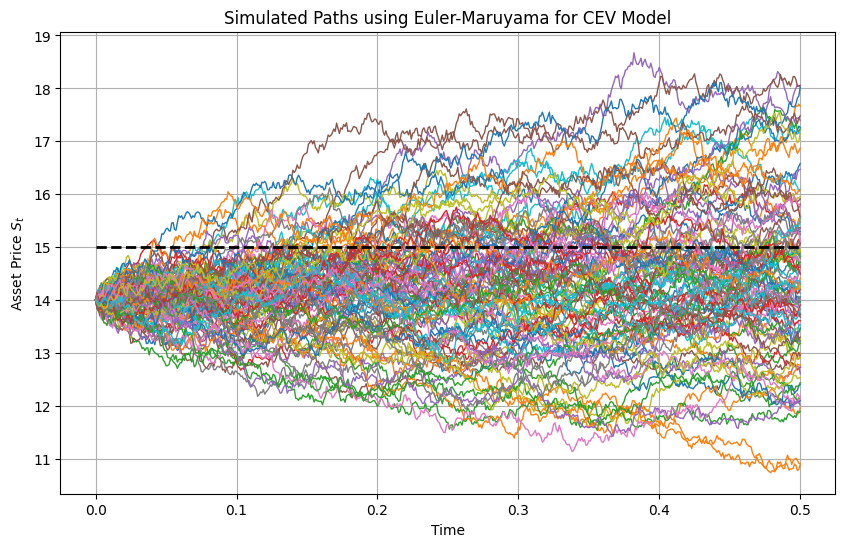

In [3]:
# Parameters for the CEV model
r = 0.1          # Risk-free rate
sigma = 0.25     # Volatility
gamma = 0.8      # Elasticity parameter (CEV parameter)
S0 = 14          # Initial value of the asset (e.g. stock price)
T = 0.5          # Time horizon
N = 500          # Number of time steps
dt = T / N       # Time step size
n_simulations = 100  # Number of simulation paths
K = 15           # Strike price of the option

# Generate random Brownian increments
dW = np.random.normal(0, np.sqrt(dt), (n_simulations, N))

# Initialize array to store the simulated paths
S = np.zeros((n_simulations, N + 1))
S[:, 0] = S0

# Euler-Maruyama method to simulate the paths
for i in range(N):
    S[:, i+1] = S[:, i] + r * S[:, i] * dt + sigma * S[:, i]**gamma * dW[:, i]

# Compute the payoff at maturity for each simulation path
payoffs_call = np.maximum(S[:, -1] - K, 0)
payoffs_put = np.maximum(K-S[:, -1], 0)

# Calculate the mean of the payoffs
mean_payoff_call = np.mean(payoffs_call)
mean_payoff_put = np.mean(payoffs_put)

# Calculate the standard deviation of the payoffs
std_payoff_call = np.std(payoffs_call)
std_payoff_put = np.std(payoffs_put)

# Discount the mean payoff to present value
call_option_price = np.exp(-r * T) * mean_payoff_call
put_option_price = np.exp(-r * T) * mean_payoff_put

# Output the call option price
print(f"European Call Option Price: {call_option_price:.4f}")
print(f"European Put Option Price: {put_option_price:.4f}")
# Plotting the simulated paths
plt.figure(figsize=(10, 6))
for j in range(n_simulations):
    plt.plot(np.linspace(0, T, N+1), S[j, :], lw=1)
# Plot the strike price
plt.plot([0, T], [K, K], 'k--', lw=2)
plt.title('Simulated Paths using Euler-Maruyama for CEV Model')
plt.xlabel('Time')
plt.ylabel('Asset Price $S_t$')
plt.grid(True)
plt.show()

Using device: cuda


100%|██████████| 800/800 [00:02<00:00, 313.59it/s]


Time step sizes:  [100, 200, 400, 800]
Discretization Errors:  [0.002616998714880303, 0.0003466577953856742, 0.0023588509983580863, 0.0010572643703978812]


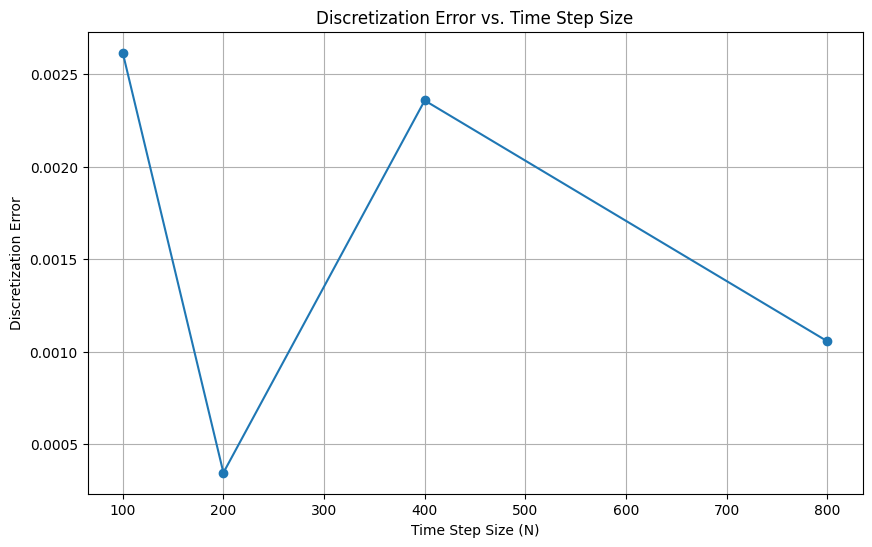

In [20]:
### DISCRETIZATION ERROR TORCH ###

# Function to simulate the option price with given time steps (N)
def simulate_option_price(N, device):
    # Parameters for the CEV model
    r = 0.1          # Risk-free rate
    sigma = 0.25     # Volatility
    gamma = 1        # Elasticity parameter (gamma=1 is the Black-Scholes case)
    S0 = 14          # Initial value of the asset (e.g. stock price)
    T = 0.5          # Time horizon
    dt = T / N       # Time step size
    n_simulations = int(1e6)  # Number of simulation paths
    K = 15           # Strike price of the option

    # Generate random walk (using PyTorch for GPU support)
    dW = torch.randn((n_simulations, N), device=device) * np.sqrt(dt)

    # Simulate asset price paths (initialize on GPU)
    S = torch.zeros((n_simulations, N + 1), device=device)
    S[:, 0] = S0

    for i in tqdm(range(N)):
        S[:, i+1] = S[:, i] + r * S[:, i] * dt + sigma * S[:, i]**gamma * dW[:, i]

    # Compute the payoff at maturity
    payoffs = torch.maximum(S[:, -1] - K, torch.tensor(0.0, device=device))
    mean_payoff = torch.mean(payoffs)
    call_option_price = torch.exp(torch.tensor(-r * T, device=device)) * mean_payoff

    # Exact price using Black-Scholes (computed on CPU for simplicity)
    F = bsexact(sigma, r, K, T, S0)

    # Compute the discretization error
    discretization_error = abs(call_option_price.item() - F)
    return discretization_error

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Run simulations with different time steps
N_values = [100, 200, 400, 800]
discretization_errors = [simulate_option_price(N, device) for N in N_values]

# Print the results
print("Time step sizes: ", N_values)
print("Discretization Errors: ", discretization_errors)

# Plot the option price as a function of the time step size
plt.figure(figsize=(10, 6))
plt.plot(N_values, discretization_errors, 'o-')
plt.title('Discretization Error vs. Time Step Size')
plt.xlabel('Time Step Size (N)')
plt.ylabel('Discretization Error')
plt.grid(True)
plt.show()


Using device: cuda


100%|██████████| 500/500 [00:00<00:00, 3458.88it/s]


Number of simulations: [100, 1000, 10000, 100000]
Sample Error: [0.17218995376162116, 0.005188050704522773, 0.014695051150842353, 0.0022067455821472848]


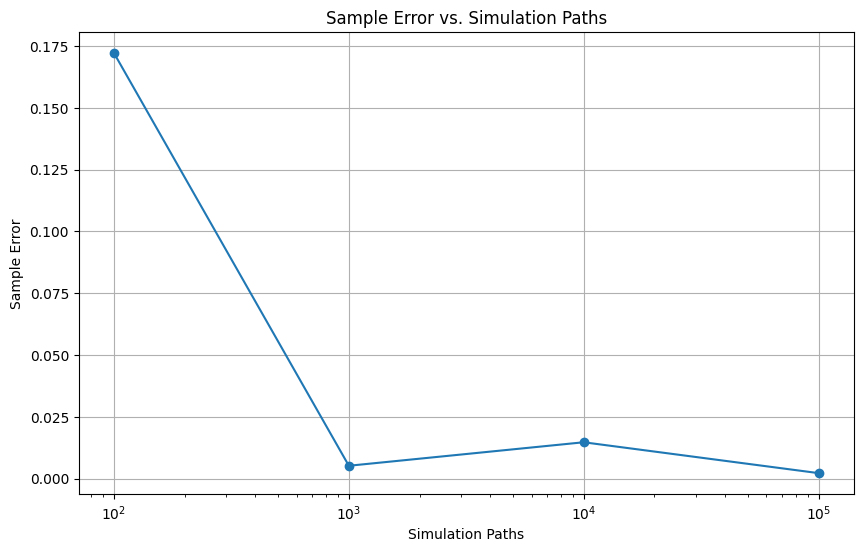

In [21]:
### SAMPLE ERROR TORCH ###

# Function to simulate the sample error with a given number of simulations
def simulate_option_price(n_simulations, device):
    # Parameters for the CEV model
    r = 0.1          # Risk-free rate
    sigma = 0.25     # Volatility
    gamma = 1        # Elasticity parameter (gamma=1 is Black-Scholes)
    S0 = 14          # Initial value of the asset (e.g. stock price)
    T = 0.5          # Time horizon
    N = 500          # Number of time steps
    dt = T / N       # Time step size
    K = 15           # Strike price of the option

    # Generate random walk (using PyTorch for GPU support)
    dW = torch.randn((n_simulations, N), device=device) * np.sqrt(dt)

    # Simulate asset price paths (initialize on GPU)
    S = torch.zeros((n_simulations, N + 1), device=device)
    S[:, 0] = S0

    for i in tqdm(range(N)):
        S[:, i+1] = S[:, i] + r * S[:, i] * dt + sigma * S[:, i]**gamma * dW[:, i]

    # Compute the payoff at maturity
    payoffs = torch.maximum(S[:, -1] - K, torch.tensor(0.0, device=device))
    mean_payoff = torch.mean(payoffs)

    # Corrected line to use torch.exp with tensors
    call_option_price = torch.exp(torch.tensor(-r * T, device=device)) * mean_payoff

    # Exact price using Black-Scholes (computed on CPU for simplicity)
    F = bsexact(sigma, r, K, T, S0)

    # Compute the sample error
    sample_error = abs(call_option_price.item() - F)

    return sample_error

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Run simulations with different number of simulation paths
n_values = [int(1e2), int(1e3), int(1e4), int(1e5)]
sample_errors = [simulate_option_price(n, device) for n in n_values]

# Print the results
print("Number of simulations:", n_values)
print("Sample Error:", sample_errors)

# Plot the sample error as a function of the number of simulations
plt.figure(figsize=(10, 6))
plt.semilogx(n_values, sample_errors, 'o-')  # Use semilogx for logarithmic X-axis
plt.title('Sample Error vs. Simulation Paths')
plt.xlabel('Simulation Paths')
plt.ylabel('Sample Error')
plt.grid(True)
plt.show()

Using device: cuda


100%|██████████| 500/500 [00:00<00:00, 1511.25it/s]


Simulation Paths: [100, 1000, 10000, 100000]
Sample Errors with Antithetic Variates: [0.05305087284512933, 0.02376830295987542, 0.007681491809411689, 0.004715743499322578]


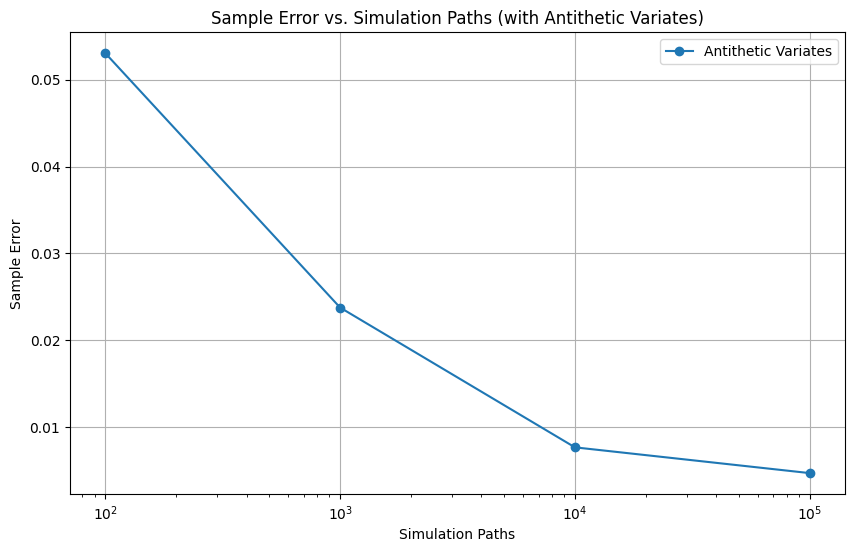

In [22]:
### ANTIHETIC VARIATES TORCH ###

# Function to simulate the sample error using antithetic variates
def simulate_option_price_antithetic(n_simulations, device):
    # Parameters for the CEV model
    r = 0.1          # Risk-free rate
    sigma = 0.25     # Volatility
    gamma = 1        # Elasticity parameter (gamma=1 is Black-Scholes)
    S0 = 14          # Initial value of the asset (e.g. stock price)
    T = 0.5          # Time horizon
    N = 500          # Number of time steps
    dt = T / N       # Time step size
    K = 15           # Strike price of the option

    # Generate Brownian motion increments for original and antithetic paths (on GPU)
    dW = torch.randn((n_simulations, N), device=device) * np.sqrt(dt)
    dW_antithetic = -dW  # Antithetic variates by negating dW

    # Simulate asset price paths for original and antithetic variables (initialize on GPU)
    S = torch.zeros((n_simulations, N + 1), device=device)
    S_antithetic = torch.zeros((n_simulations, N + 1), device=device)

    S[:, 0] = S0
    S_antithetic[:, 0] = S0

    for i in tqdm(range(N)):
        # Original path
        S[:, i+1] = S[:, i] + r * S[:, i] * dt + sigma * S[:, i]**gamma * dW[:, i]
        # Antithetic path
        S_antithetic[:, i+1] = S_antithetic[:, i] + r * S_antithetic[:, i] * dt + sigma * S_antithetic[:, i]**gamma * dW_antithetic[:, i]

    # Compute payoffs for both original and antithetic paths
    payoffs = torch.maximum(S[:, -1] - K, torch.tensor(0.0, device=device))
    payoffs_antithetic = torch.maximum(S_antithetic[:, -1] - K, torch.tensor(0.0, device=device))

    # Average the payoffs from original and antithetic paths
    mean_payoff = torch.mean((payoffs + payoffs_antithetic) / 2)

    # Discounted payoff (call option price)
    call_option_price = torch.exp(torch.tensor(-r * T, device=device)) * mean_payoff

    # Exact price using Black-Scholes formula (computed on CPU for simplicity)
    F = bsexact(sigma, r, K, T, S0)

    # Calculate sample error
    sample_error = abs(call_option_price.item() - F)

    return sample_error

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Run simulations with different numbers of paths using antithetic variates
n_values = [int(1e2), int(1e3), int(1e4), int(1e5)]
sample_errors_antithetic = [simulate_option_price_antithetic(n, device) for n in n_values]

# Print the results
print("Simulation Paths:", n_values)
print("Sample Errors with Antithetic Variates:", sample_errors_antithetic)

# Plot the sample error as a function of the number of simulations using antithetic variates
plt.figure(figsize=(10, 6))
plt.semilogx(n_values, sample_errors_antithetic, 'o-', label="Antithetic Variates")  # Use semilogx for logarithmic X-axis
plt.title('Sample Error vs. Simulation Paths (with Antithetic Variates)')
plt.xlabel('Simulation Paths')
plt.ylabel('Sample Error')
plt.grid(True)
plt.legend()
plt.show()

Using device: cuda
Time Steps: [50, 100, 200, 400]
Discretization Errors (Milstein): [0.0008232565350096976, 0.0016272096209961617, 0.0006108312182862008, 0.00027316526837761756]


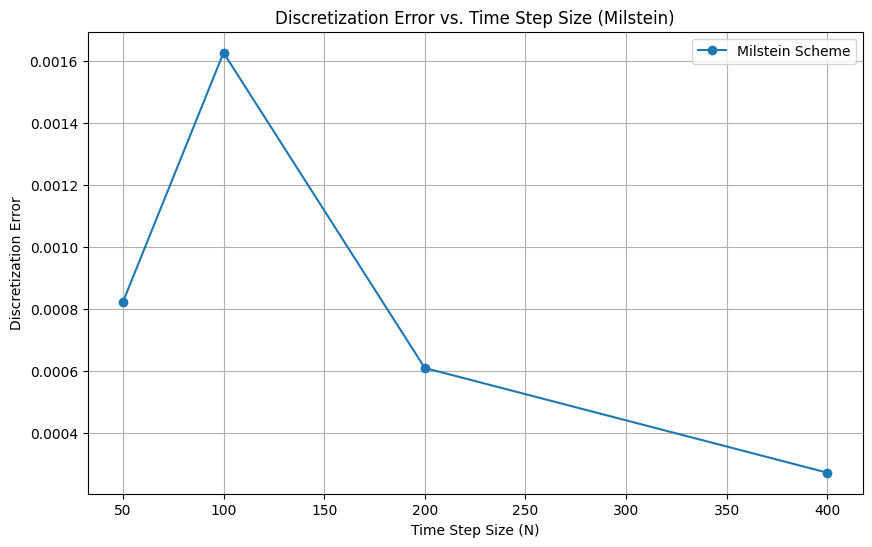

In [23]:
### DISCRETIZATION ERROR WITH MILSTEIN SCHEME TORCH ###

# Function to simulate the option price using Milstein scheme with given time steps (N)
def simulate_option_price_milstein(N, device):
    # Parameters for the CEV model
    r = 0.1          # Risk-free rate
    sigma = 0.25     # Volatility
    gamma = 1        # Elasticity parameter (gamma=1 is Black-Scholes)
    S0 = 14          # Initial value of the asset (e.g. stock price)
    T = 0.5          # Time horizon
    dt = T / N       # Time step size
    n_simulations = int(1e6)  # Number of simulation paths
    K = 15           # Strike price of the option

    # Generate standard Brownian increments (on GPU)
    dW = torch.randn((n_simulations, N), device=device) * np.sqrt(dt)

    # Simulate paths using the Milstein scheme (initialize on GPU)
    S = torch.zeros((n_simulations, N + 1), device=device)
    S[:, 0] = S0

    for i in range(N):
        S_current = S[:, i]

        # Drift and diffusion terms
        drift = r * S_current
        diffusion = sigma * S_current**gamma

        # Milstein step (includes drift, diffusion, and correction term)
        S[:, i+1] = S_current + drift * dt + diffusion * dW[:, i] + 0.5 * sigma * gamma * S_current**(gamma-1) * (dW[:, i]**2 - dt)

    # Compute the payoff at maturity
    payoffs = torch.maximum(S[:, -1] - K, torch.tensor(0.0, device=device))
    mean_payoff = torch.mean(payoffs)

    # Discounted payoff (call option price)
    call_option_price = torch.exp(torch.tensor(-r * T, device=device)) * mean_payoff

    # Exact price using Black-Scholes formula (computed on CPU for simplicity)
    F = bsexact(sigma, r, K, T, S0)

    # Compute discretization error
    discretization_error = abs(call_option_price.item() - F)
    return discretization_error

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Run simulations with different time steps using Milstein scheme
N_values = [50, 100, 200, 400]
discretization_errors_milstein = [simulate_option_price_milstein(N, device) for N in N_values]

# Print the results
print("Time Steps:", N_values)
print("Discretization Errors (Milstein):", discretization_errors_milstein)

# Plot the discretization error as a function of the time step size
plt.figure(figsize=(10, 6))
plt.plot(N_values, discretization_errors_milstein, 'o-', label='Milstein Scheme')
plt.title('Discretization Error vs. Time Step Size (Milstein)')
plt.xlabel('Time Step Size (N)')
plt.ylabel('Discretization Error')
plt.grid(True)
plt.legend()
plt.show()

Using device: cuda


100%|██████████| 400/400 [00:01<00:00, 237.97it/s]


Time Steps: [50, 100, 200, 400]
Discretization Errors (Runge-Kutta): [0.11230999513201301, 0.11152583642534797, 0.11505323930315559, 0.11208921952776496]


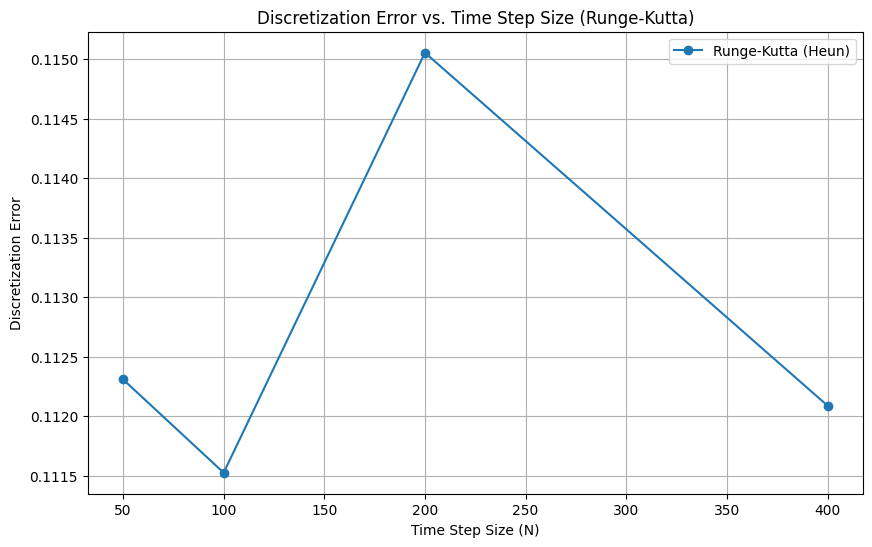

In [24]:
### DISCRETIZATION ERROR WITH RUNGE-KUTTA TORCH ###

# Function to simulate the option price using Runge-Kutta (Heun's method) with given time steps (N)
def simulate_option_price_runge_kutta(N, device):
    # Parameters for the CEV model
    r = 0.1          # Risk-free rate
    sigma = 0.25     # Volatility
    gamma = 1        # Elasticity parameter (gamma=1 is Black-Scholes)
    S0 = 14          # Initial value of the asset (e.g. stock price)
    T = 0.5          # Time horizon
    dt = T / N       # Time step size
    n_simulations = int(1e6)  # Number of simulation paths
    K = 15           # Strike price of the option

    # Generate standard Brownian increments (on GPU)
    dW = torch.randn((n_simulations, N), device=device) * np.sqrt(dt)

    # Simulate paths using Runge-Kutta 2nd order (Heun's method) on GPU
    S = torch.zeros((n_simulations, N + 1), device=device)
    S[:, 0] = S0

    for i in tqdm(range(N)):
        S_current = S[:, i]

        # Euler-Maruyama step (predictor)
        drift = r * S_current
        diffusion = sigma * S_current**gamma
        S_predict = S_current + drift * dt + diffusion * dW[:, i]

        # Drift and diffusion for the predictor step
        drift_predict = r * S_predict
        diffusion_predict = sigma * S_predict**gamma

        # Heun's method (corrector)
        S[:, i+1] = S_current + 0.5 * (drift + drift_predict) * dt + 0.5 * (diffusion + diffusion_predict) * dW[:, i]

    # Compute the payoff at maturity
    payoffs = torch.maximum(S[:, -1] - K, torch.tensor(0.0, device=device))
    mean_payoff = torch.mean(payoffs)

    # Discounted payoff (call option price)
    call_option_price = torch.exp(torch.tensor(-r * T, device=device)) * mean_payoff

    # Exact price using Black-Scholes formula (computed on CPU for simplicity)
    F = bsexact(sigma, r, K, T, S0)

    # Compute discretization error
    discretization_error = abs(call_option_price.item() - F)
    return discretization_error

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Run simulations with different time steps using Runge-Kutta (Heun's method)
N_values = [50, 100, 200, 400]
discretization_errors_runge_kutta = [simulate_option_price_runge_kutta(N, device) for N in N_values]

# Print the results
print("Time Steps:", N_values)
print("Discretization Errors (Runge-Kutta):", discretization_errors_runge_kutta)

# Plot the discretization error as a function of the time step size
plt.figure(figsize=(10, 6))
plt.plot(N_values, discretization_errors_runge_kutta, 'o-', label='Runge-Kutta (Heun)')
plt.title('Discretization Error vs. Time Step Size (Runge-Kutta)')
plt.xlabel('Time Step Size (N)')
plt.ylabel('Discretization Error')
plt.grid(True)
plt.legend()
plt.show()

Using device: cuda


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


Gamma Values: [0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
Option Prices: [0.15169210731983185, 0.2982059419155121, 0.5471433997154236, 0.9774530529975891, 1.7927495241165161, 3.674337148666382, nan, nan, nan, nan]


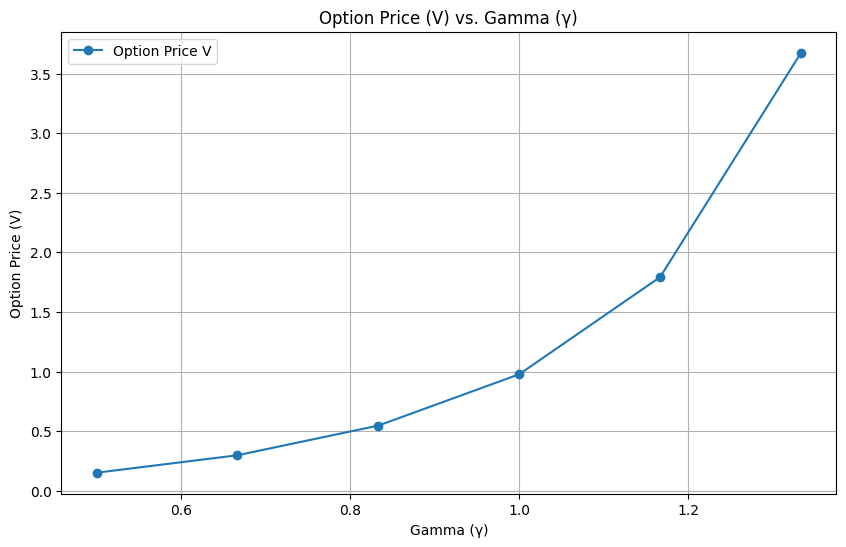

In [25]:
### GAMMA TORCH ###

# Function to compute the option price as a function of gamma using PyTorch
def compute_option_price_for_gamma(gamma, N=500, device='cpu'):
    # Parameters for the CEV model
    r = 0.1          # Risk-free rate
    sigma = 0.25     # Volatility
    S0 = 14          # Initial value of the asset (e.g. stock price)
    T = 0.5          # Time horizon
    dt = T / N       # Time step size
    n_simulations = int(1e6)  # Number of simulation paths
    K = 15           # Strike price of the option

    # Generate standard Brownian increments (on GPU)
    dW = torch.randn((n_simulations, N), device=device) * np.sqrt(dt)

    # Simulate paths using Runge-Kutta 2nd order (Heun's method) on GPU
    S = torch.zeros((n_simulations, N + 1), device=device)
    S[:, 0] = S0

    for i in range(N):
        S_current = S[:, i]

        # Euler-Maruyama step (predictor)
        drift = r * S_current
        diffusion = sigma * S_current**gamma
        S_predict = S_current + drift * dt + diffusion * dW[:, i]

        # Drift and diffusion for the predictor step
        drift_predict = r * S_predict
        diffusion_predict = sigma * S_predict**gamma

        # Heun's method (corrector)
        S[:, i+1] = S_current + 0.5 * (drift + drift_predict) * dt + 0.5 * (diffusion + diffusion_predict) * dW[:, i]

    # Compute the payoff at maturity
    payoffs = torch.maximum(S[:, -1] - K, torch.tensor(0.0, device=device))
    mean_payoff = torch.mean(payoffs)

    # Discounted payoff (call option price)
    call_option_price = torch.exp(torch.tensor(-r * T, device=device)) * mean_payoff

    return call_option_price.item()

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Range of gamma values to test
gamma_values = np.linspace(0.5, 1.0, 10)  # Change the range as needed

# Compute the option prices for different gamma values
option_prices = [compute_option_price_for_gamma(gamma, device=device) for gamma in tqdm(gamma_values)]

# Print the results
print("Gamma Values:", gamma_values)
print("Option Prices:", option_prices)

# Plot the option price as a function of gamma
plt.figure(figsize=(10, 6))
plt.plot(gamma_values, option_prices, 'o-', label='Option Price V')
plt.title('Option Price (V) vs. Gamma (γ)')
plt.xlabel('Gamma (γ)')
plt.ylabel('Option Price (V)')
plt.grid(True)
plt.legend()
plt.show()